In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from tensorflow.keras import Model

from epi.models import Model
from epi.normalizing_flows import Arch, CouplingArch, AutoregressiveArch

print(tf.__version__)
# Mac OS jupyter kernel dies without
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

2.1.0


In [2]:
arch = AutoregressiveArch(4, 1, 2, 10, True)
N = 200

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


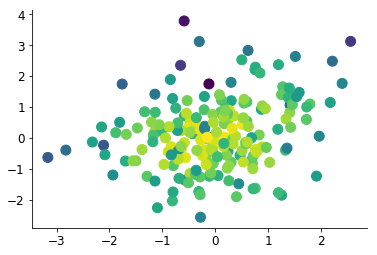

In [3]:
x, log_q_x = arch(N)
plt.figure()
plt.scatter(x[:,1], x[:,2], c=log_q_x)
plt.show()

In [4]:
init_params = {'loc':0., 'scale':1.}
arch.initialize('iso_gauss', init_params)

eta [ 0.   0.   0.   0.  -0.5 -0.  -0.  -0.  -0.  -0.5 -0.  -0.  -0.  -0.
 -0.5 -0.  -0.  -0.  -0.  -0.5]
0 tf.Tensor(-2.9946017, shape=(), dtype=float32)
1000 tf.Tensor(-3.6725078, shape=(), dtype=float32)
2000 tf.Tensor(-3.66642, shape=(), dtype=float32)
3000 tf.Tensor(-3.6751177, shape=(), dtype=float32)
4000 tf.Tensor(-3.6742997, shape=(), dtype=float32)
5000 tf.Tensor(-3.6745882, shape=(), dtype=float32)
6000 tf.Tensor(-3.677244, shape=(), dtype=float32)
7000 tf.Tensor(-3.675313, shape=(), dtype=float32)
8000 tf.Tensor(-3.6786647, shape=(), dtype=float32)
9000 tf.Tensor(-3.6733794, shape=(), dtype=float32)


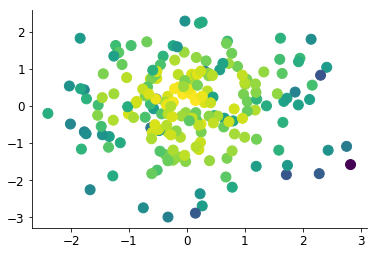

In [6]:
x, log_q_x = arch(N)
plt.figure()
plt.scatter(x[:,1], x[:,2], c=log_q_x)
plt.show()
